First add the data functions to the path

In [1]:
import sys
import numpy as np
import pandas as pd
import xarray as xr
import copy
from netCDF4 import Dataset
from pathlib import Path
from datetime import datetime, timedelta
notebook_dir = !pwd # Replace with !echo %cd% if using windows
library_dir = Path(notebook_dir[0]).parent.absolute()
sys.path.append(str(library_dir))
data_raw_path = library_dir / 'data' / 'raw' / 'adcp'
glider_raw_path = library_dir / 'data' / 'raw' / 'glider'
fig_path = library_dir / 'reports' / 'figures'
from src.data.adcp_mission_analysis import adcp_import_data, add_dive_averages, read_glider_nc
#from src.data.beam_mapping import beam2enu, beam_from_center, caltran

Use better plotting defaults

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style_path = library_dir / 'src' / 'visualization' / 'presentation.mplstyle'
style.use(str(style_path))

In [3]:
overview, mission_dict = adcp_import_data(data_raw_path)


/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/media/callum/storage/Documents/adcp-glider/src/data/adcp_mission_analysis.py:456: RuntimeWarning: Mean of empty slice
  vel_referenced = vel - np.tile(np.nanmean(vel, 0) - ref_vel, (len(bin_centers), 1))


Add beam attributes. These are taken from the fifth cell (11.3 m from the glider on default settings) and averaged over each ascent/descent profile

In [4]:
beam_attrs, adcp_df = add_dive_averages(overview, mission_dict)
beam_attrs
# overview.join(beam_attrs)

,cor_beam_1,cor_beam_2,cor_beam_3,cor_beam_4,amp_beam_1,amp_beam_2,amp_beam_3,amp_beam_4,beam_miss,pitch,roll,heading,good_angle_5,good_angle_all,good_cor_5,good_cor_all
0000a,NaN,3.266667,3.000000,3.400000,NaN,27.466667,27.100000,27.200000,3.095026,-46.674664,4.855333,127.181343,0.000000,0.000000,0.000000,0.000000
0001a,NaN,20.106383,16.425532,17.212766,NaN,29.670213,29.042553,29.351064,2.697399,-42.630852,4.440851,235.983398,6.382979,6.382979,16.879433,13.049645
0001b,46.821429,48.857143,NaN,46.321429,33.696429,33.294643,NaN,32.857143,1.875847,-12.929286,4.590000,184.708572,32.142857,5.357143,47.857143,36.428571
0002a,NaN,63.545455,62.800000,62.709091,NaN,34.881818,34.563636,34.345455,1.607731,-29.559093,5.614909,115.971268,40.000000,38.181818,66.545455,48.404040
0002b,88.183333,87.666667,NaN,86.350000,37.816667,37.258333,NaN,36.741667,0.898507,16.158834,5.542000,134.029495,60.000000,48.333333,92.555556,66.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0153b,96.581395,96.069767,NaN,95.697674,42.767442,42.116279,NaN,41.523256,0.777380,25.423719,2.500698,106.601860,83.720930,0.000000,99.379845,84.702842
0154a,NaN,92.705882,93.235294,94.705882,NaN,39.029412,40.470588,39.705882,1.549429,-26.010000,3.985883,35.480000,47.058824,5.882353,99.215686,74.248366
0154b,95.785714,95.142857,NaN,95.142857,41.714286,41.000000,NaN,40.642857,0.983536,24.104288,4.052857,97.740715,64.285714,0.000000,99.523810,82.222222
0155a,NaN,93.888889,91.925926,93.592593,NaN,39.648148,40.092593,39.000000,1.377177,-26.317038,4.590370,180.342194,33.333333,0.000000,99.506173,76.131687


In [5]:
adcp_df.head()

,cast_num,pressure_ad,pitch_ad,roll_ad,heading_ad
2019-11-27 11:46:45.063199,0000a,1.872,-58.609997,-2.31,279.559998
2019-11-27 11:46:46.063199,0000a,1.894,-58.590000,-2.34,279.649994
2019-11-27 11:46:47.063199,0000a,1.907,-58.590000,-2.34,278.329987
2020-01-19 13:37:16.063199,0000a,2.228,-43.169998,-6.47,89.809998
2020-01-19 13:37:17.063300,0000a,2.159,-42.419998,-5.19,88.759995


Check that the data start when you expect. The first file in particular may have data from a previous sim dive or bench test. adapt the following cell to select the data starting on the correct day

In [6]:
# For this dataset, need to remove the data before 23 Jan they are from 2019 benchtests and 2020 sim dives
adcp_df = adcp_df['2020-01-23':]

In [7]:
def savefig(figname, extension='png'):
    plt.savefig(fig_path / str(figname+'.'+extension),format=extension,dpi='figure', bbox_inches='tight')

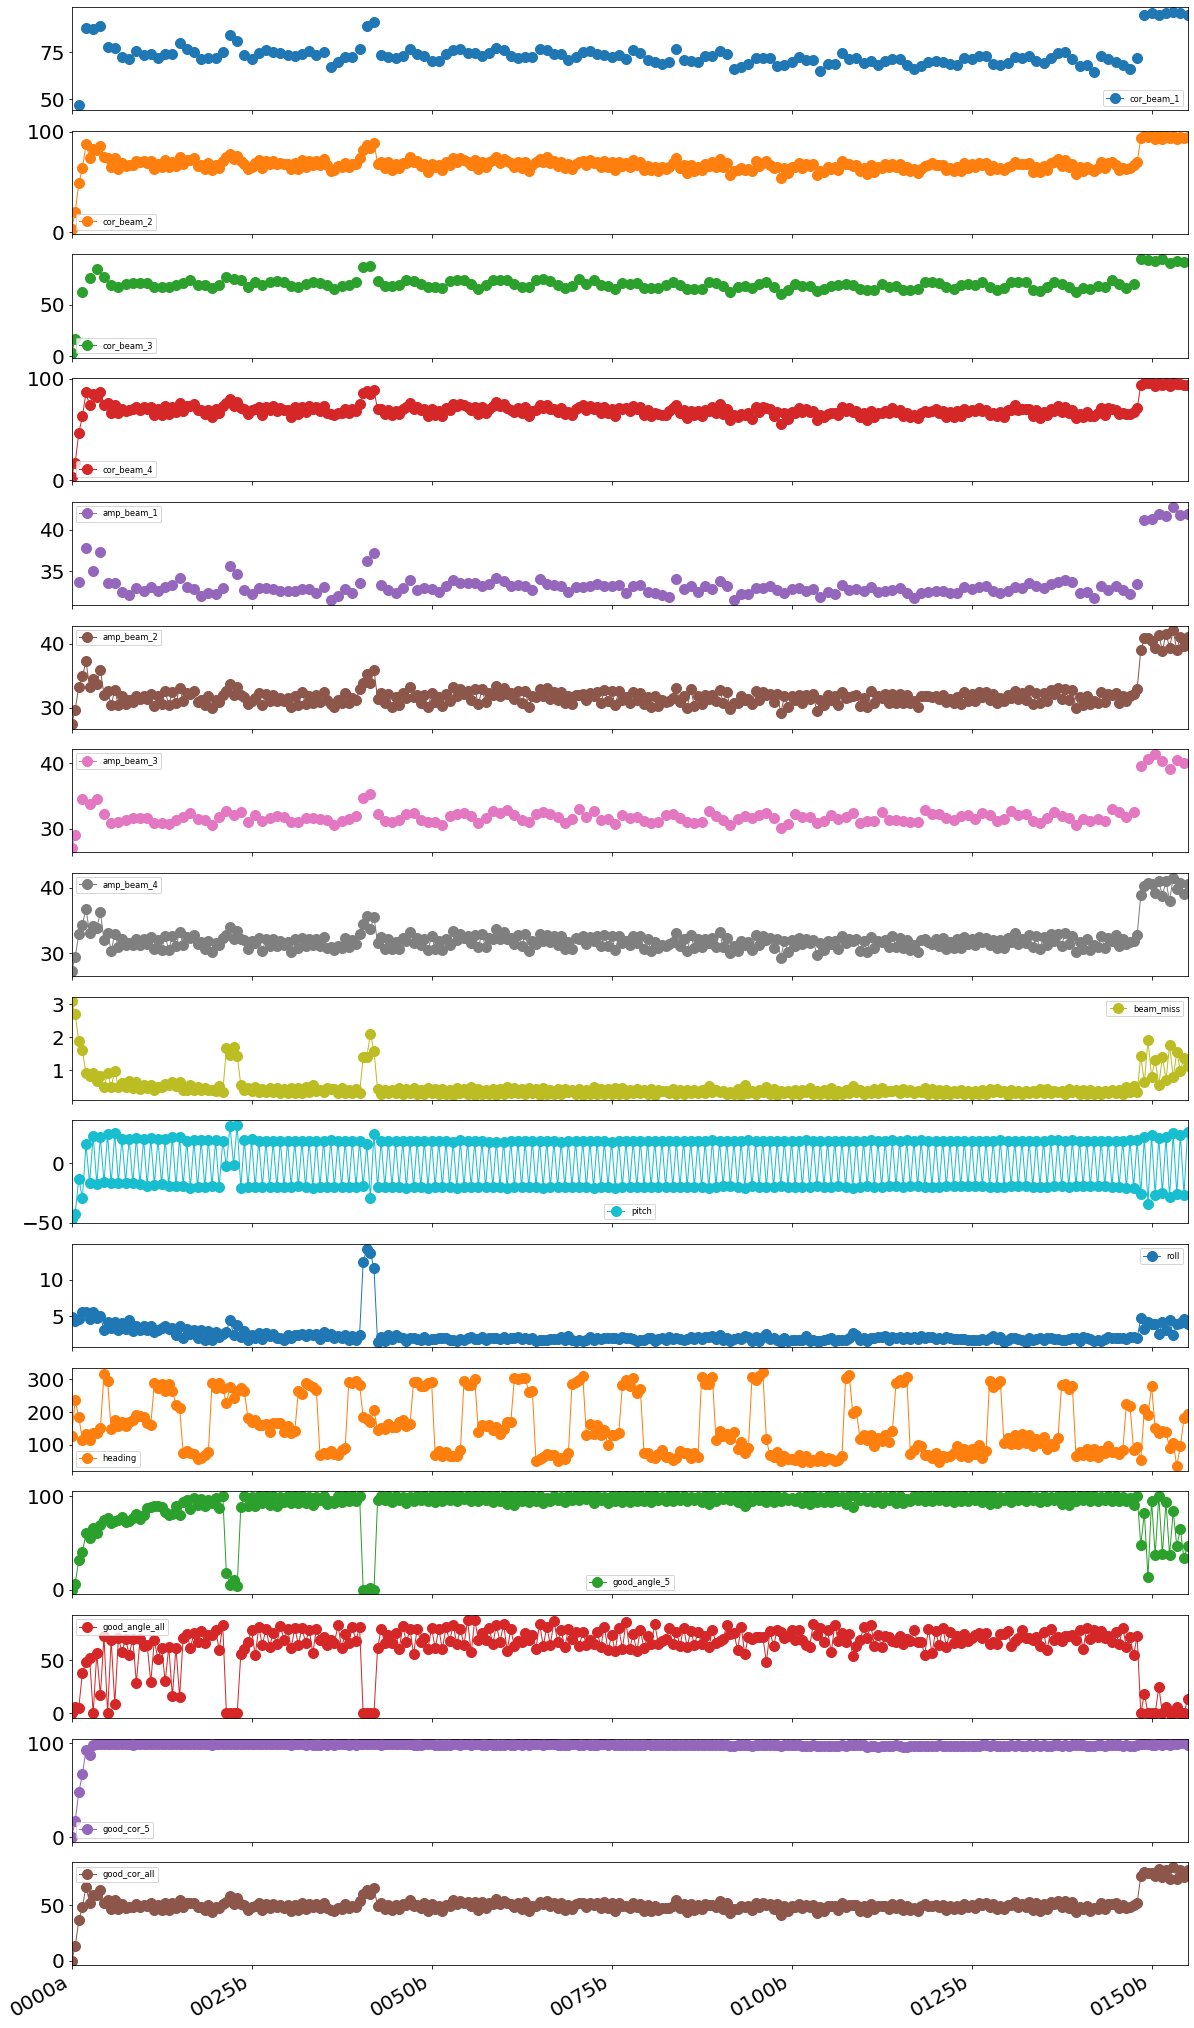

In [8]:
beam_attrs.plot(subplots=True,figsize=(20,40),marker='o');
savefig('beam_attributes')

See which variables are correlated between the dive limbs

In [9]:
beam_attrs.corr()

,cor_beam_1,cor_beam_2,cor_beam_3,cor_beam_4,amp_beam_1,amp_beam_2,amp_beam_3,amp_beam_4,beam_miss,pitch,roll,heading,good_angle_5,good_angle_all,good_cor_5,good_cor_all
cor_beam_1,1.000000,0.983177,NaN,0.985372,0.877339,0.851349,NaN,0.862749,0.442984,0.567374,0.469145,0.152680,-0.413841,-0.626208,0.388738,0.925396
cor_beam_2,0.983177,1.000000,0.981218,0.991133,0.919162,0.852555,0.832654,0.863438,0.112729,0.305218,0.369582,0.078162,-0.228063,-0.409651,0.550261,0.966269
cor_beam_3,NaN,0.981218,1.000000,0.987316,NaN,0.721227,0.770405,0.747329,-0.086476,0.321879,0.240175,-0.002077,-0.102804,-0.243906,0.747249,0.955565
cor_beam_4,0.985372,0.991133,0.987316,1.000000,0.899158,0.824080,0.812397,0.846183,0.073697,0.317701,0.353599,0.081815,-0.197454,-0.382607,0.592916,0.961182
amp_beam_1,0.877339,0.919162,NaN,0.899158,1.000000,0.992642,NaN,0.992875,0.528746,0.301951,0.370030,0.076453,-0.413927,-0.683986,0.036441,0.975576
amp_beam_2,0.851349,0.852555,0.721227,0.824080,0.992642,1.000000,0.983467,0.993587,0.386736,0.297454,0.391381,0.028152,-0.381579,-0.582437,0.114937,0.922585
amp_beam_3,NaN,0.832654,0.770405,0.812397,NaN,0.983467,1.000000,0.985113,0.439245,-0.229615,0.432657,-0.042958,-0.514222,-0.672941,0.212960,0.901334
amp_beam_4,0.862749,0.863438,0.747329,0.846183,0.992875,0.993587,0.985113,1.000000,0.370606,0.318357,0.395909,0.045151,-0.373341,-0.575485,0.144874,0.932412
beam_miss,0.442984,0.112729,-0.086476,0.073697,0.528746,0.386736,0.439245,0.370606,1.000000,-0.270939,0.661112,0.091373,-0.933429,-0.845823,-0.588786,0.143630
pitch,0.567374,0.305218,0.321879,0.317701,0.301951,0.297454,-0.229615,0.318357,-0.270939,1.000000,0.036398,0.068349,0.214956,0.179322,0.201447,0.310434


Load in glider attitude data for comparison with that from the ADCP. A mismatch may indicate physcal misalignment of the glider and ADCP or a poor calibration of the accelerometers in either unit.

In [10]:
glider_df = read_glider_nc(glider_raw_path / 'sg637_full_timeseries.nc')
glider_df

,DAC_u,DAC_v,abs_salinity,conductivity,cons_temp,depth,direction,dive,dive_num,lat,...,rho,salinity,salinity_nocorr,sigma0,temp,roll,pitch,heading,w_H2O,glider_time
2020-01-23 14:35:40.870005,-0.084725,0.065625,35.601190,55.756318,26.966234,1.340919,-1.0,1.0,1.0,14.183558,...,1023.058349,35.433673,35.433673,1023.052657,26.980132,10.5,-50.6,97.6,-0.001678,2020-01-23 14:35:40.870005
2020-01-23 14:35:46.834999,-0.084725,0.065625,35.601343,55.761965,26.971450,1.350925,-1.0,1.0,1.0,14.183558,...,1023.056837,35.433825,35.429688,1023.051102,26.985348,1.4,-55.2,128.8,-0.005775,2020-01-23 14:35:46.834999
2020-01-23 14:35:54.732995,-0.084725,0.065625,35.605989,55.759010,26.962315,1.420973,-1.0,1.0,1.0,14.183558,...,1023.063478,35.438449,35.436477,1023.057446,26.976428,5.5,-60.7,117.6,-0.014122,2020-01-23 14:35:54.732995
2020-01-23 14:36:01.007001,-0.084725,0.065625,35.601852,55.760088,26.968771,1.551062,-1.0,1.0,1.0,14.183558,...,1023.058918,35.434331,35.433727,1023.052334,26.982740,-4.3,-64.2,128.3,-0.003273,2020-01-23 14:36:01.007001
2020-01-23 14:36:06.963999,-0.084725,0.065625,35.612017,55.772225,26.966604,1.461000,-1.0,1.0,1.0,14.183558,...,1023.066718,35.444448,35.442142,1023.060517,26.980960,11.2,-66.4,120.9,0.004194,2020-01-23 14:36:06.963999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-16 13:58:34.845004,-0.052225,0.004649,35.711597,55.535589,26.609093,4.433003,1.0,155.0,155.0,14.182904,...,1023.266628,35.543544,35.544124,1023.247793,26.628579,-6.3,37.0,209.2,0.019803,2020-02-16 13:58:34.845004
2020-02-16 13:58:39.844001,-0.052225,0.004649,35.712441,55.538799,26.611685,3.322260,1.0,155.0,155.0,14.182895,...,1023.261708,35.544389,35.544758,1023.247593,26.630946,-8.9,36.5,219.3,0.043055,2020-02-16 13:58:39.844001
2020-02-16 13:58:44.847001,-0.052225,0.004649,35.712781,55.540981,26.614227,1.861273,1.0,155.0,155.0,14.182887,...,1023.254946,35.544736,35.544210,1023.247038,26.633164,0.0,23.2,227.3,0.072271,2020-02-16 13:58:44.847001
2020-02-16 13:58:49.845003,-0.052225,0.004649,35.709926,55.538544,26.616121,1.290884,1.0,155.0,155.0,14.182883,...,1023.249816,35.541897,35.541011,1023.244331,26.634813,-8.5,6.1,234.2,0.064037,2020-02-16 13:58:49.845003


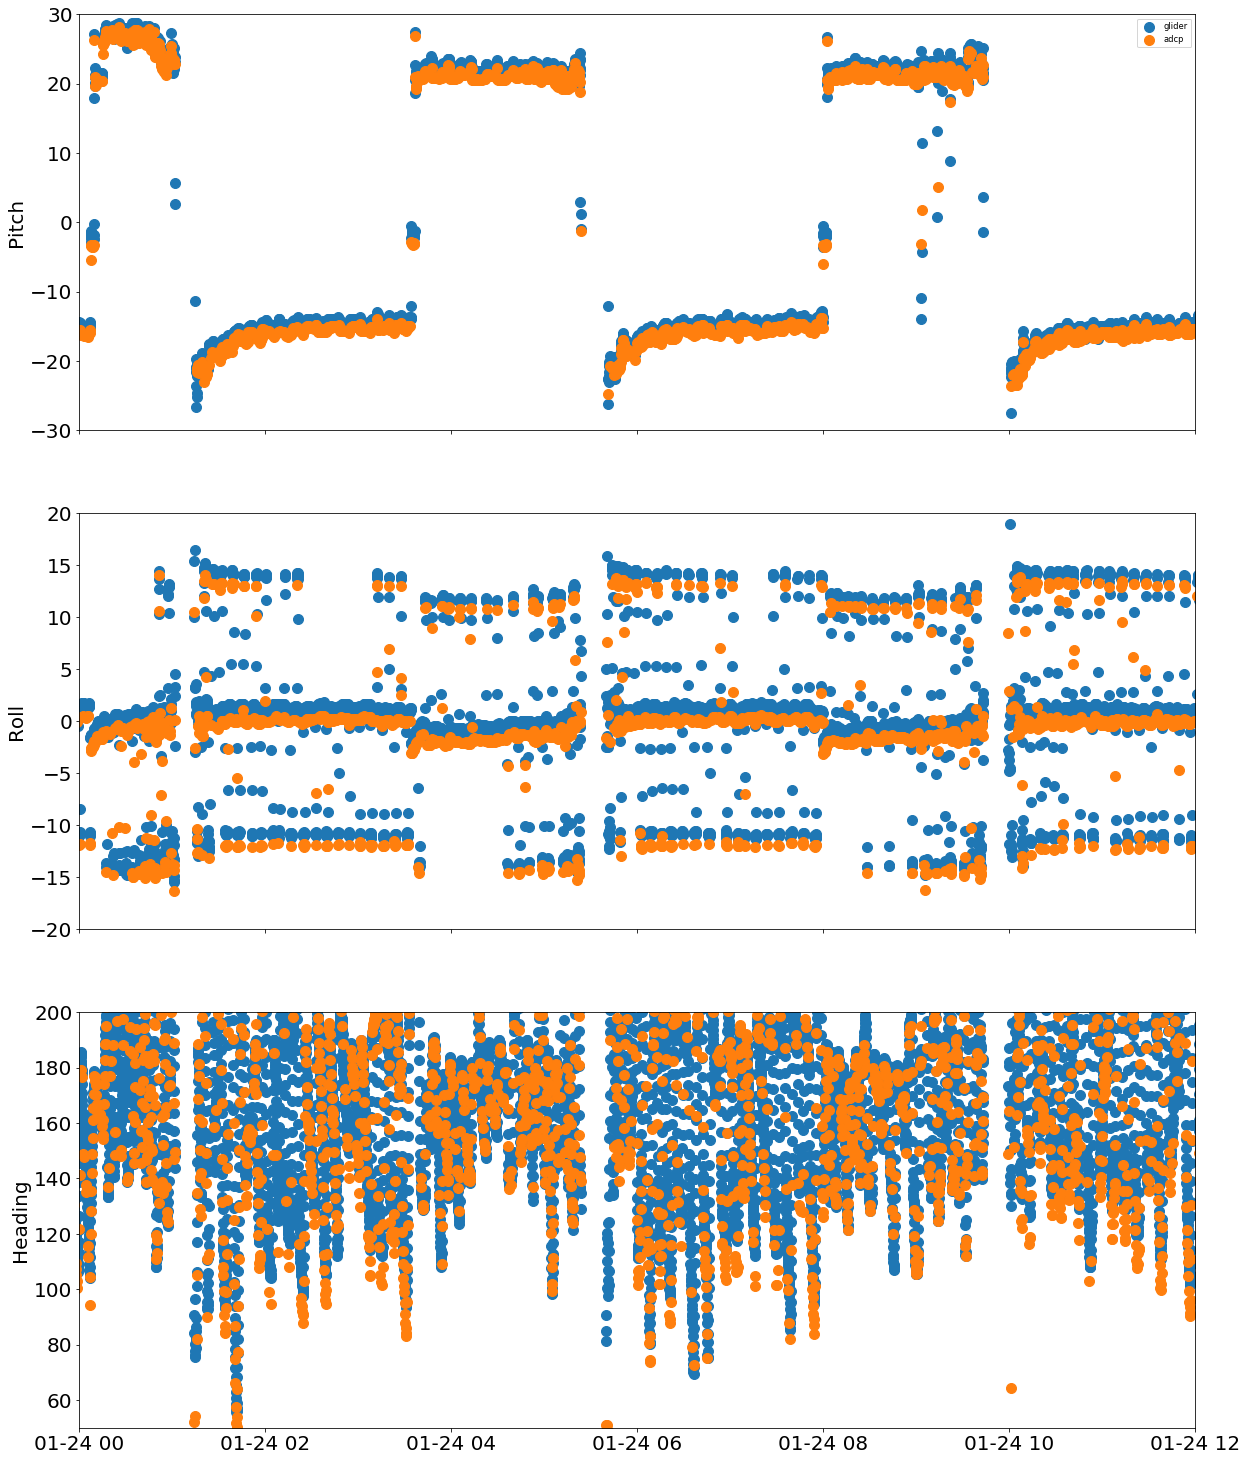

In [11]:
fig, ax = plt.subplots(3,1,figsize=(20,26), sharex=True)
ax = ax.ravel()
ax[0].scatter(glider_df.index, glider_df.pitch, label='glider')
ax[0].scatter(adcp_df.index, adcp_df.pitch_ad, label='adcp')
ax[0].set(xlim=[datetime(2020,1,24,0), datetime(2020,1,24,12)], ylim=[-30,30], ylabel='Pitch')
ax[1].scatter(glider_df.index, glider_df.roll)
ax[1].scatter(adcp_df.index, adcp_df.roll_ad)
ax[1].set(ylim=[-20,20], ylabel='Roll')
ax[2].scatter(glider_df.index, glider_df.heading)
ax[2].scatter(adcp_df.index, adcp_df.heading_ad)
ax[2].set(ylim=[50,200], ylabel='Heading')
ax[0].legend();
savefig('attitude_glider_vs_adcp')

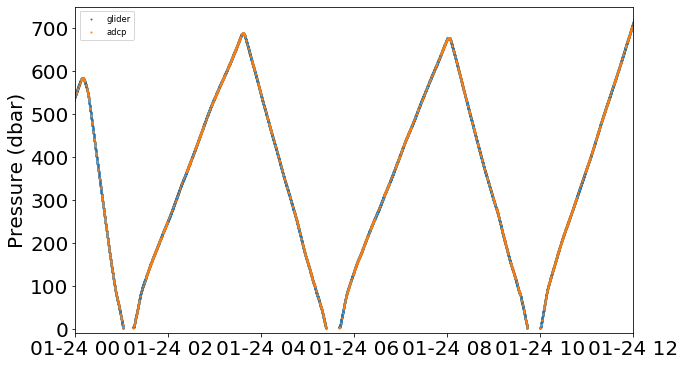

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(glider_df.index, glider_df.pressure, label='glider', s=1)
ax.scatter(adcp_df.index, adcp_df.pressure_ad, label='adcp', s=1)
ax.set(xlim=[datetime(2020,1,24,0), datetime(2020,1,24,12)],ylim = [-10,750], ylabel='Pressure (dbar)')
ax.legend()
savefig('pressure_glider_vs_adcp')

After 40 dives, the glider should be trimmed and on deep dives. we will use this as a sample dive to check coordinate transforms

In [13]:
foo = mission_dict['0041a']
bar = mission_dict['0041b']

Plot the xyz velocites from one dive cycle. Upper panel dive, lower panel climb

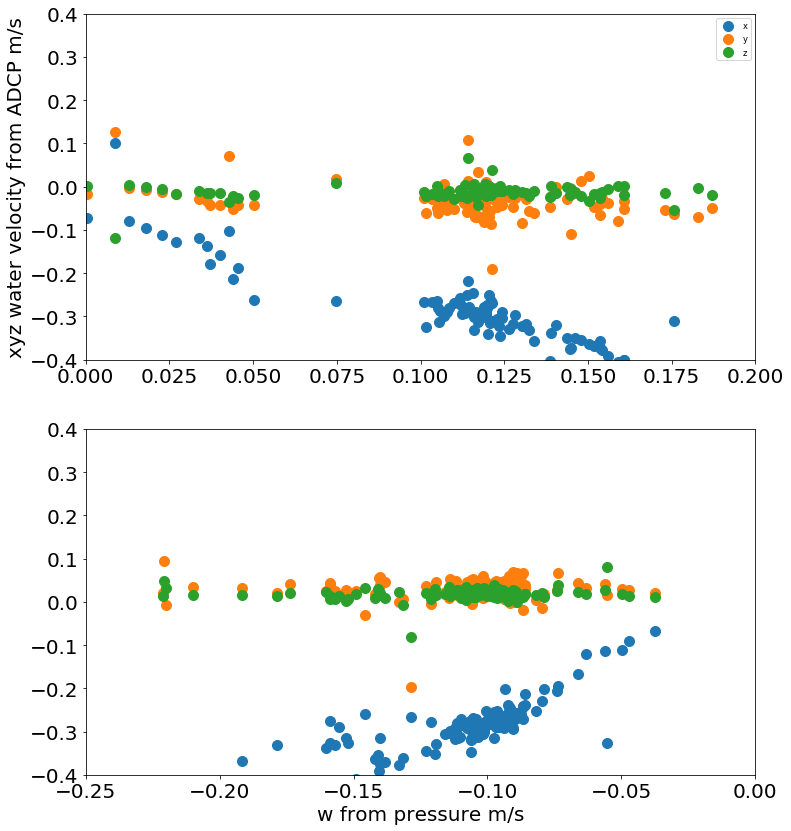

In [14]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,0,0][:-1], label='x')
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,0,1][:-1], label='y')
ax[0].scatter(-foo.glider_w_from_p,foo.vel_xyz[:,0,2][:-1], label='z')
ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='xyz water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,0,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,0,1][:-1], label='y')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_xyz[:,0,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
savefig('xyz_vel_dive41')

As above for enu velocites

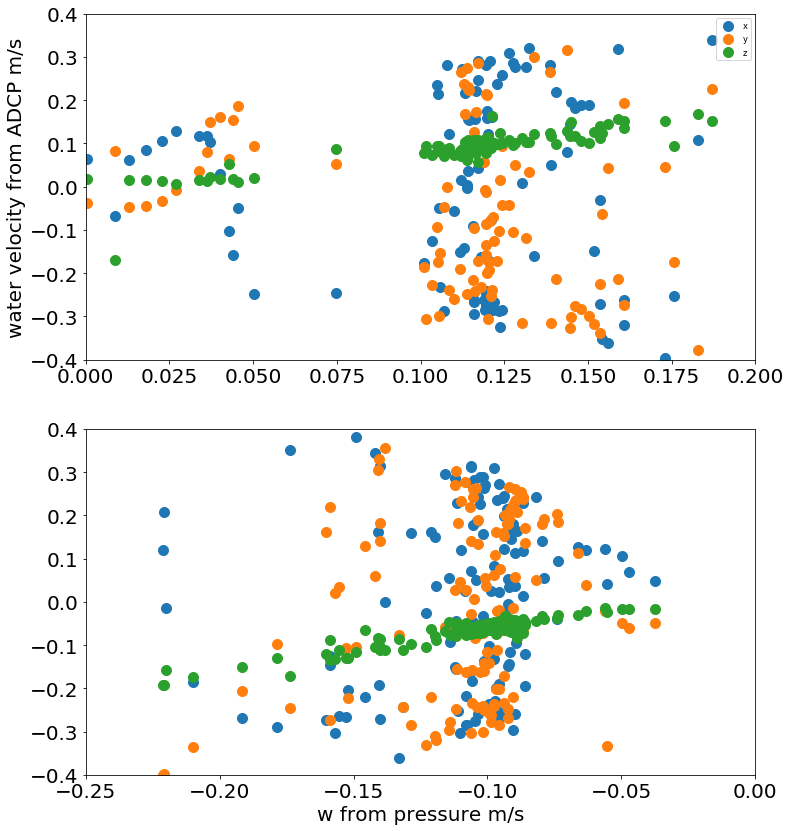

In [15]:
fig, ax = plt.subplots(2,1, figsize=(12,14), sharex=False)
ax = ax.ravel()
ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,0][:-1], label='x')
ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,1][:-1], label='y')
ax[0].scatter(-foo.glider_w_from_p,foo.vel_enu[:,0,2][:-1], label='z')
ax[0].set(xlim=[0,0.2], ylim=[-0.4,0.4],ylabel='water velocity from ADCP m/s')
ax[0].legend()
ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,0][:-1], label='x')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,1][:-1], label='y')
ax[1].scatter(-bar.glider_w_from_p,bar.vel_enu[:,0,2][:-1], label='z')
ax[1].set(xlim=[-0.25,0.], ylim=[-0.4,0.4], xlabel='w from pressure m/s')
savefig('enu_vel_dive41')

In [16]:
all_the_shear = np.empty((len(mission_dict),100,3))
all_the_amp = np.empty((len(mission_dict),100,3))

in_bin = np.empty((len(mission_dict), 100))
for i, dive in enumerate(mission_dict.keys()):
    all_the_shear[i,:,:] = mission_dict[dive].vel_referenced
    in_bin[i,:] = mission_dict[dive].no_in_bin
    all_the_amp[i,:] = mission_dict[dive].amp_binned


In [17]:
np.shape(all_the_amp)

(311, 100, 3)

/home/callum/anaconda3/envs/adcp-glider/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


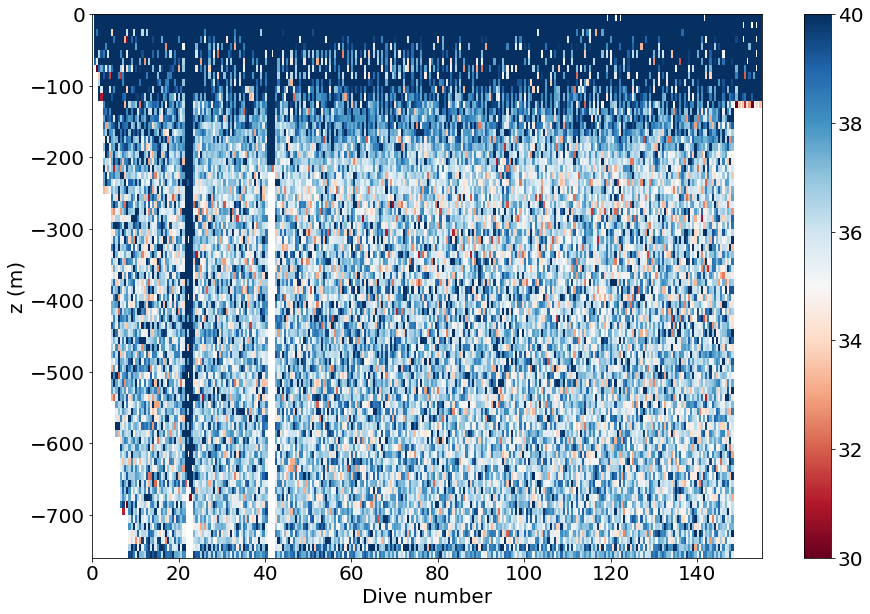

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
nos = ax.pcolor(np.arange(0,len(overview.index)/2,0.5), np.arange(-1000,10,10),np.transpose(np.nanmean(all_the_amp,2)),vmin=30, vmax=40, cmap='RdBu')
ax.set(ylim=[-760,0], ylabel='z (m)', xlabel='Dive number', label='return_amp')
fig.colorbar(mappable=nos,ax=ax)
savefig('return_amp')

Check how many adcp velocity shear measurements were used in each cell of the velocity profile

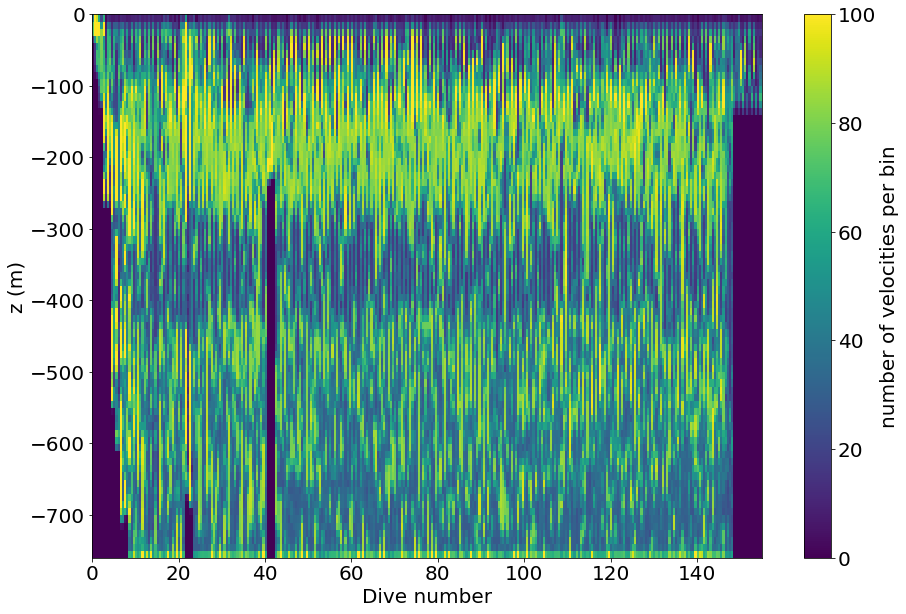

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
nos = ax.pcolor(np.arange(0,len(overview.index)/2,0.5), np.arange(-1000,10,10),np.transpose(in_bin), vmin=0, vmax=100, cmap='viridis')
ax.set(ylim=[-760,0], ylabel='z (m)', xlabel='Dive number')
fig.colorbar(mappable=nos,ax=ax, label='number of velocities per bin')
savefig('vels_per_bin')

Plot the shear profiles

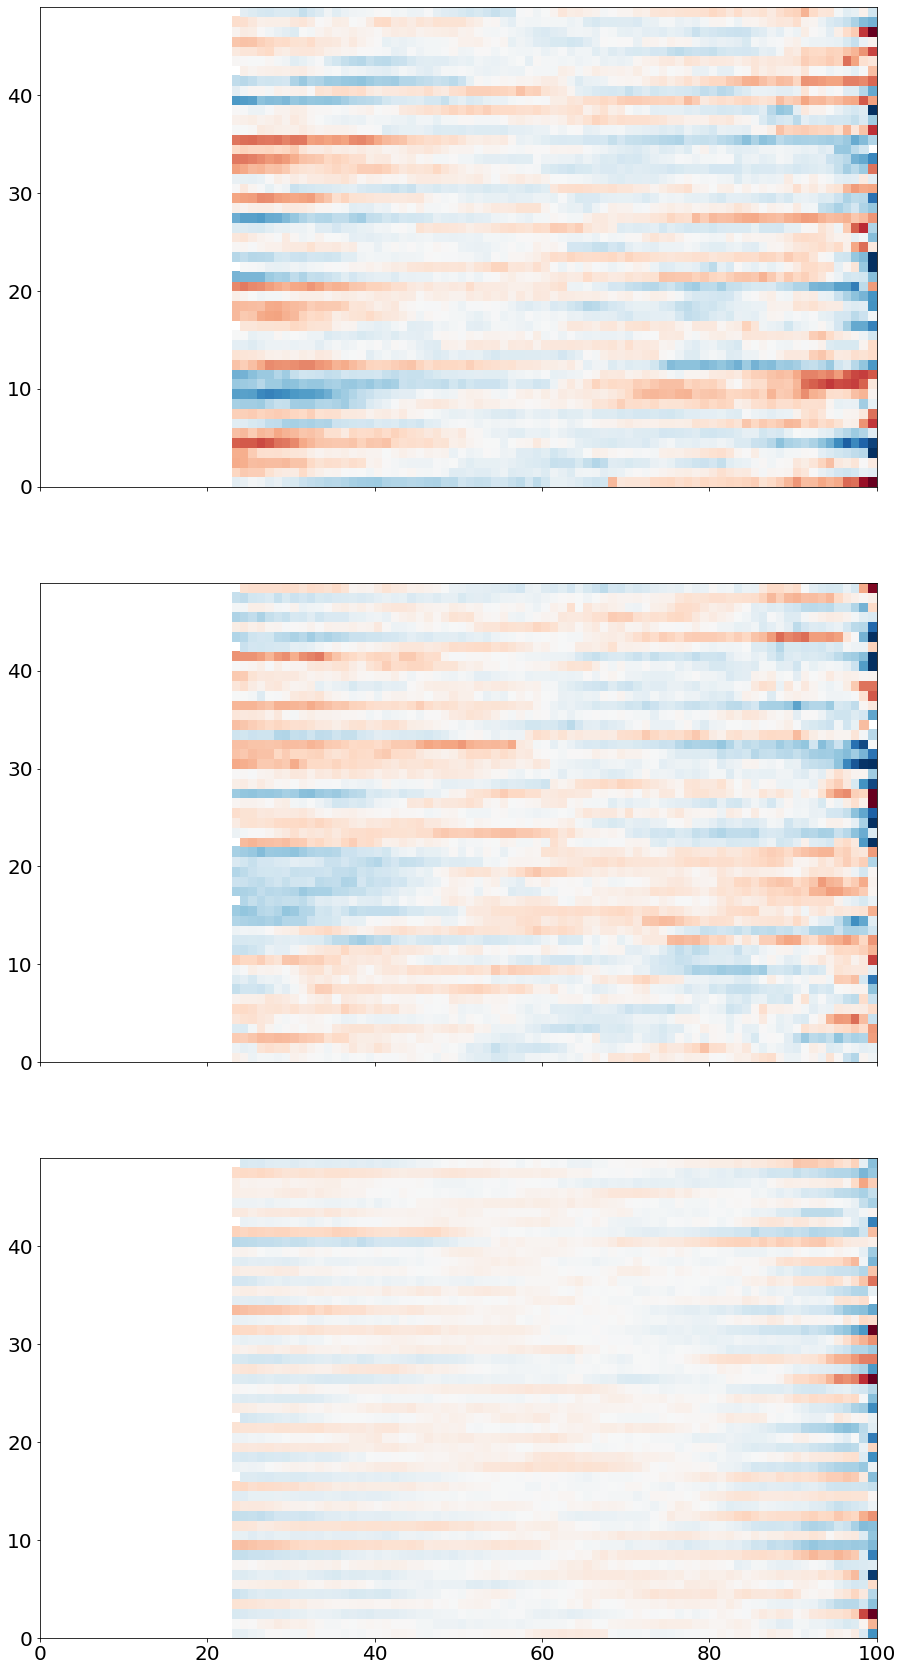

In [20]:
fig, ax = plt.subplots(3,1, figsize=(15,30), sharex=True)
ax = ax.ravel()
ax[0].pcolor(all_the_shear[101:150,:,0], cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax[1].pcolor(all_the_shear[101:150,:,1], cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax[2].pcolor(all_the_shear[101:150,:,2], cmap='RdBu_r', vmin=-0.5, vmax=0.5)

-------------------
# Rough stuff